In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Training a neural network with numpy 

This notebook shows how to train a simple neural network to approximate a non-linear function, using only the library `numpy`. 

More specifically, we are lookings for the weights of a network with one hidden layer to approximate the function $y=\sin(x)$ on the domain $(-\pi,\pi)$. 

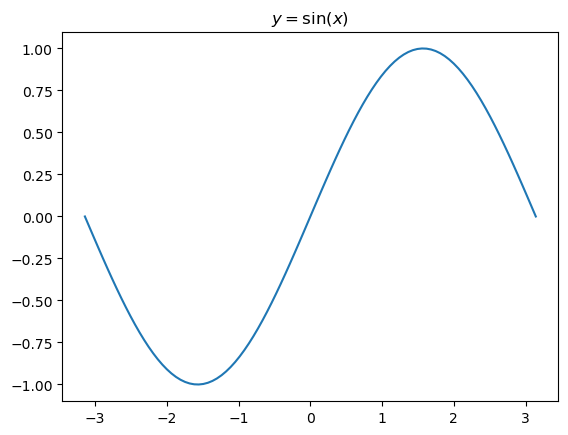

In [17]:
x = np.linspace(-np.pi, np.pi, 100)
y = np.sin(x)

plt.plot(x, y)
plt.title(r'$y=\sin(x)$')
plt.show()

## Forward-pass

### Neural network definition

A neural network is a parameterized function that maps an input vector
$ x_b $ to an output vector $ \hat{y} $:
$$
\hat{y} = f(x_b;\,\theta),
$$
where $ \theta $ denotes a collection of parameters (weights and biases).

The function $ f(\cdot) $ is constructed by stacking simple building blocks of the form:

- a linear transformation,
- followed by a nonlinear transformation.

Concretely, each layer applies an affine map and then a nonlinearity:
$$
z = x W + b,
\qquad
a = \sigma(z),
$$
and the output of one layer becomes the input to the next.


### Network example 

We will use a simple network structure in this example: 

- Batched inputs: $x_b$
- First layer: $z_1 = x_b W_1 + b_1$, $a_1 = \tanh(z_1)$
- Output layer: $\hat y = a_1 W_2 + b_2$

It is important to get the dimensions right:

- $N_x$: input dimension (here 1)
- $N_b$: batch size
- $N_h$: number of neurons (width) in the hidden/nonlinear feature layer
- $N_y$: output dimension (here 1)

The main objects have the following shapes:

- $x_b \in \mathbb{R}^{N_b \times N_x}$
- $W_1 \in \mathbb{R}^{N_x \times N_h}$
- $b_1 \in \mathbb{R}^{1 \times N_h}$ (broadcasted across the (B) rows)
- $z_1, a_1 \in \mathbb{R}^{N_b \times N_h}$
- $W_2 \in \mathbb{R}^{N_h \times N_y}$
- $b_2 \in \mathbb{R}^{1 \times N_y}$ (broadcasted across the (B) rows)
- $\hat y \in \mathbb{R}^{N_b \times N_y}$

### Activation functions 

In this example, we use the $\tanh$ function, defined as 
$$\tanh(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}$$

Note that, if we didn't have a non-linear activation function, the network would simply be a linear transformation, and optimizing the weights would amount to doing a linear regression to fit a non-linear function. 

The $\tanh$ function has the following properties
- Output between 0 and 1 
- Zero centered: $\tanh(0)=0$ 
- Simple derivative: $\tanh'(x)=1-\tanh(x)^2$
- Smooth

We could choose another nonlinear function (and indeed, many people do so), such as the

- ReLu: $y=\max(0,x)$
- Sigmoid: $y=1/(1+e^{-x})$

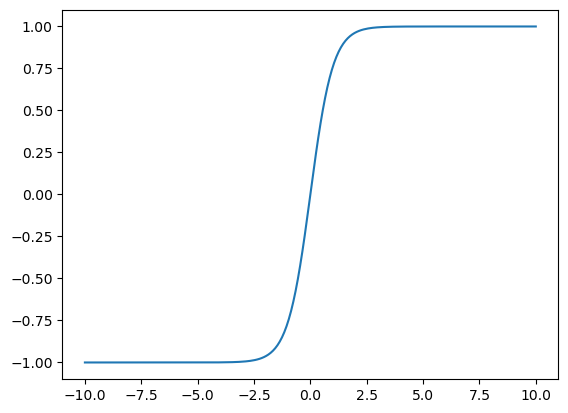

In [ ]:
def tanh(z):
    return np.tanh(z)

x = np.linspace(-10, 10, 200)
y = np.tanh(x)
plt.plot(x, y)
plt.show()

Once the dimensions are right, simulating the network (i.e. doing a forward-pass), given some inputs $xb$ and some weights $W_1,b_1,W_2,b_2$ is simple.

First, fix some values for the parameters and draw some data.

In [18]:
Nx = 1
Nb = 3 
Nh = 10
Ny = 1

# Initialize weights and biases at random values
W1 = np.random.randn(Nx, Nh)
b1 = np.random.randn(Nh)
W2 = np.random.randn(Nh, Ny)
b2 = np.random.randn(Ny)

# draw random input batch
xb = np.random.uniform(-np.pi, np.pi, size=(Nb, 1))

Then, by applying the affine and non-linear transformation.

In [12]:
def tanh(z):
    return np.tanh(z)

# First layer
z1 = xb @ W1 + b1      # (B, H)
a1 = tanh(z1)          # (B, H)

# Second layer (output layer)
yhat = a1 @ W2 + b2    # (B, 1)

In [13]:
# Putting it all together in a function 

def forward(xb, W1, b1, W2, b2):
    z1 = xb @ W1 + b1      # (B, H)
    a1 = tanh(z1)          # (B, H)
    yhat = a1 @ W2 + b2    # (B, 1)
    cache = (xb, z1, a1, yhat)
    return yhat, cache

## Backward-propagation

Training the network amounts to finding the values of the parameters $\theta$ (composed of $W_1,W_2,b_1,b_2$) such that some loss function is minimized. In this case, we will choose the mean of squared errors:
$$L(\theta)= \frac{1}{N_b}\sum_i(\hat{y_i}-y_i)^2).$$

Our goal is to compute $\frac{\partial L(\theta)}{\partial \theta}$, in order to do stochastic gradient descent, which is 
$$\theta' = \theta - \eta \nabla_\theta L(\theta)$$
where $\nabla_\theta$ is the gradient. 

We call the step of computing the gradient the "backward-step" or "backward propagation". 

In [14]:
def dtanh(z):
    # derivative wrt pre-activation z: 1 - tanh(z)^2
    t = np.tanh(z)
    return 1.0 - t**2


def backward(cache, yb, W2):
    xb, z1, a1, yhat = cache
    B = xb.shape[0]

    # MSE loss: L = mean((yhat - y)^2)
    # dL/dyhat = 2*(yhat - y)/B
    dy = (2.0 / B) * (yhat - yb)            # (B, 1)

    # yhat = a1 W2 + b2
    dW2 = a1.T @ dy                         # (H, 1)
    db2 = dy.sum(axis=0, keepdims=True)     # (1, 1)
    da1 = dy @ W2.T                         # (B, H)

    # a1 = tanh(z1)
    dz1 = da1 * dtanh(z1)                   # (B, H)

    # z1 = x W1 + b1
    dW1 = xb.T @ dz1                         # (1, H)
    db1 = dz1.sum(axis=0, keepdims=True)     # (1, H)

    return dW1, db1, dW2, db2



## Stochastic-Gradient Descent (SGD) and training

In [ ]:
np.random.seed(0)

n = 512
x = np.random.uniform(-np.pi, np.pi, size=(n, 1))
y = np.sin(x)

# Normalize inputs (helps training)
x_mean, x_std = x.mean(), x.std()
x_n = (x - x_mean) / x_std

# ----------------------------
# 2) MLP: 1 -> H -> 1 with tanh, trained "manually"
#    Forward + backward written by hand (no autodiff)
# ----------------------------
H = 32
W1 = 0.1 * np.random.randn(1, H)
b1 = np.zeros((1, H))
W2 = 0.1 * np.random.randn(H, 1)
b2 = np.zeros((1, 1))


In [7]:
# ----------------------------
# 3) Training loop (SGD)
# ----------------------------
lr = 1e-1
batch = 128
steps = 150_000

for t in range(steps):
    idx = np.random.randint(0, n, size=batch)
    xb = x_n[idx]
    yb = y[idx]

    yhat, cache = forward(xb)
    loss = np.mean((yhat - yb) ** 2)

    dW1, db1, dW2, db2 = backward(cache, yb)

    # SGD update
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2

    if (t + 1) % 500 == 0:
        print(f"step {t+1:4d} | loss {loss:.6f}")



TypeError: forward() missing 4 required positional arguments: 'W1', 'b1', 'W2', and 'b2'

In [ ]:
# ----------------------------
# 4) Quick evaluation (no plotting needed)
# ----------------------------
# Test on a grid
x_test = np.linspace(-np.pi, np.pi, 200).reshape(-1, 1)
x_test_n = (x_test - x_mean) / x_std
y_test = np.sin(x_test)

y_pred, _ = forward(x_test_n)
mse = np.mean((y_pred - y_test) ** 2)
print("test MSE:", mse)


# ----------------------------
# 4) Plot prediction vs true function
# ----------------------------
x_grid = np.linspace(-np.pi, np.pi, 400).reshape(-1, 1)
y_true = np.sin(x_grid)

x_grid_n = (x_grid - x_mean) / x_std
y_pred, _ = forward(x_grid_n)

plt.figure(figsize=(8, 4.5))
plt.plot(x_grid, y_true, label="true: sin(x)", linewidth=2)
plt.plot(x_grid, y_pred, label="NN prediction", linewidth=2)
plt.scatter(x[:200], y[:200], s=10, alpha=0.25, label="train samples (subset)")
plt.axhline(0, color="black", linewidth=0.5)
plt.title("Manual NN (NumPy) fit: prediction vs true function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()